In [10]:
import copy
from math import *

import pandas as pd
import numpy as np
import scipy
from scipy import stats
from scipy.stats import kstest
from scipy.stats import boxcox
import scipy.linalg as linalg

from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'

In [13]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 1. Check Multicollinearity

In [16]:
y, X = dmatrices('charges ~ age + bmi + children + sex + smoker + region', data=df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif["Multicollinearity"] = vif["VIF Factor"] >= 10
vif

,VIF Factor,features,Multicollinearity
0,35.527488,Intercept,True
1,1.008900,sex[T.male],False
2,1.012074,smoker[T.yes],False
3,1.518823,region[T.northwest],False
4,1.652230,region[T.southeast],False
5,1.529411,region[T.southwest],False
6,1.016822,age,False
7,1.106630,bmi,False
8,1.004011,children,False


## 2.  Fit in the model

In [14]:
model = smf.ols('charges ~ age + bmi + children + sex + smoker + region', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:06:30   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.194e+04    987.819    -12.086      0.000   -1.39e+04      -1e+04
sex[T.male]          -131.3144    332.945     -0.394      0.693    -784.470     521.842
smoker[T.yes]        2.385e+04    413.153     57.723      0.000     2.3e+04    2.47e+04
region[T.northwest]  -352.9639    476.276     -0.741      0.459   -1287.298     581.370
region[T.southeast] -1035.0220    478.692     -2.162      0.031   -1974.097     -95.947
region[T.southwest]  -960.0510    477.933     -2.009      0.045   -1897.636     -22.466
age                   256.8564     11.899     21.587      0.000     233.514     280.199
bmi                   339.1935     28.599     11.860      0.000     283.088     395.298
children              475.5005    137.804      3.451      0.001     205.163     745.838
==============================================================================
Omnibus:                      300.366   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              718.887
Skew:                           1.211   Prob(JB):                    7.86e-157
Kurtosis:                       5.651   Cond. No.                         311.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3. Check Influential Points

### (1) Check Externally Studentized Residuals

In [19]:
infl = model.get_influence()
ex_studti = infl.resid_studentized_external

n = len(ex_studti)
k = model.df_model + 1

seuil_stud = scipy.stats.t.ppf(0.975, df=n-k-1)
atyp_stud = np.abs(ex_studti) >= seuil_stud

ex_studenti = pd.DataFrame()
ex_studenti['Index of Position'] = df.index[atyp_stud]
ex_studenti['External Studendized Residual'] = ex_studti[atyp_stud]
ex_studenti['Original Residuals'] = list(model.resid[atyp_stud])
ex_studenti

,Index of Position,External Studendized Residual,Original Residuals
0,3,3.025106,18229.640447
1,9,2.827391,17038.499402
2,34,3.385694,20361.808397
3,62,2.871484,17297.049593
4,102,3.062004,18445.160075
...,...,...,...
69,1211,2.340278,14132.995558
70,1230,3.682901,22115.563048
71,1258,2.345691,14140.115257
72,1300,5.009599,29992.764417


### (2) Check Cook's Distance

In [20]:
infl = model.get_influence()
inflsum = infl.summary_frame()

reg_cook = inflsum.cooks_d
atyp_cook = np.abs(reg_cook) >= 4/n

cooki = pd.DataFrame()
cooki['Index of Position'] = df.index[atyp_cook]
cooki['Cook\'s Distance'] = list(reg_cook[atyp_cook])
cooki

,Index of Position,Cook's Distance
0,3,0.005871
1,9,0.005871
2,34,0.010236
3,62,0.006641
4,69,0.002991
...,...,...
82,1306,0.003067
83,1307,0.003160
84,1314,0.002992
85,1317,0.003358


### (3) Delete data points selected from both of these methods

In [35]:
df_droppoints = df
influencial_points = set(ex_studenti['Index of Position']).union(set(cooki['Index of Position']))

for i in influencial_points:
    df_droppoints = df_droppoints.drop(index=i, axis =1)
    
df_droppoints.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620
4,32,male,28.88,0,no,northwest,3866.8552
5,31,female,25.74,0,no,southeast,3756.6216


## 4. Check Heteroscedasticity

In [36]:
# fit in the new model
model_droppoints = smf.ols('charges ~ age + bmi + children + sex + smoker + region', data=df_droppoints).fit()
model_droppoints.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     971.9
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:23:16   Log-Likelihood:                -12091.
No. Observations:                1237   AIC:                         2.420e+04
Df Residuals:                    1228   BIC:                         2.425e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.103e+04    737.327    -14.961      0.000   -1.25e+04   -9584.896
sex[T.male]           -96.4388    244.242     -0.395      0.693    -575.616     382.739
smoker[T.yes]          2.5e+04    309.654     80.741      0.000    2.44e+04    2.56e+04
region[T.northwest]  -949.8945    350.953     -2.707      0.007   -1638.428    -261.361
region[T.southeast]  -976.3730    352.469     -2.770      0.006   -1667.881    -284.865
region[T.southwest]  -919.4873    349.349     -2.632      0.009   -1604.875    -234.100
age                   253.1093      8.716     29.038      0.000     236.009     270.210
bmi                   282.3776     21.518     13.123      0.000     240.162     324.593
children              505.9924    101.315      4.994      0.000     307.223     704.762
==============================================================================
Omnibus:                       35.135   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.649
Skew:                          -0.207   Prob(JB):                     2.49e-14
Kurtosis:                       4.022   Cond. No.                         318.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### (1) Residual vs. Fitted Value Plot

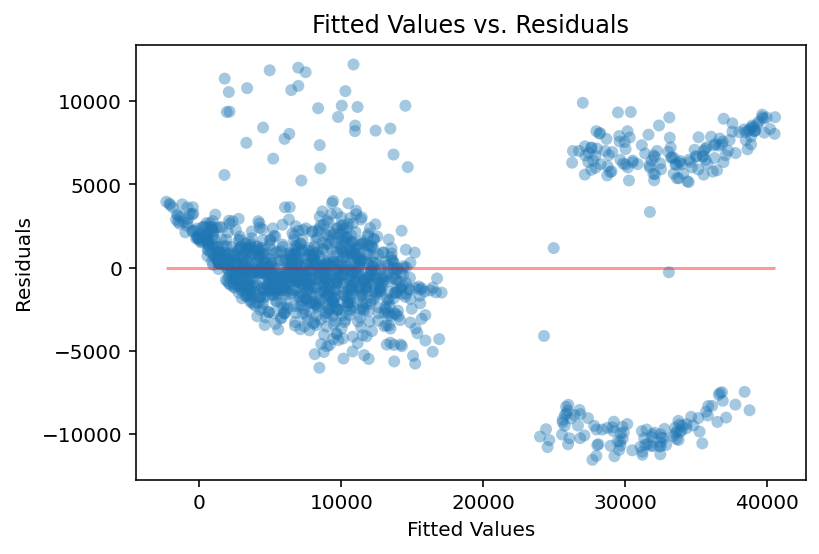

In [37]:
fittedvals = model_droppoints.fittedvalues
residuals = model_droppoints.resid

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(fittedvals, residuals, alpha=0.4, edgecolors='none')
ax.hlines(0, xmin=min(fittedvals), xmax=max(fittedvals), colors='r', alpha=0.4)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted Values vs. Residuals")
plt.show()

### (2) Breush-Pagan test

In [264]:
bp_test = het_breuschpagan(model_droppoints.resid, model_droppoints.model.exog)
labels = ['BP Statistic', 'BP-Test p-value']
bp_result = dict(zip(labels, bp_test))
if bp_result['BP-Test p-value'] < 0.05:
    print('Reject H0, there’s a significant heteroscedasticity problem at the 95% confidence level.')
else:
    print('Can\'t reject H0, there’s no significant heteroscedasticity problem at the 95% confidence level.')

Reject H0, there’s a significant heteroscedasticity problem at the 95% confidence level.


### (3) Log Transformation

In [271]:
charges = df_droppoints['charges']
# charges_max = max(charges) + 1e-10
charges_log = [log(max(charges) + 1e-10 - i) for i in charges] # charges_max - i
model_log = smf.ols('charges_log ~ age + bmi + children + sex + smoker + region', data=df_droppoints).fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            charges_log   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     52.75
Date:                Sun, 29 Nov 2020   Prob (F-statistic):           1.12e-73
Time:                        22:35:01   Log-Likelihood:                -1719.0
No. Observations:                1237   AIC:                             3456.
Df Residuals:                    1228   BIC:                             3502.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              11.8492      0.168     70.400      0.000      11.519      12.179
sex[T.male]            -0.0500      0.056     -0.897      0.370      -0.159       0.059
smoker[T.yes]          -1.2844      0.071    -18.171      0.000      -1.423      -1.146
region[T.northwest]     0.0379      0.080      0.473      0.637      -0.119       0.195
region[T.southeast]    -0.0518      0.080     -0.643      0.520      -0.210       0.106
region[T.southwest]     0.0328      0.080      0.412      0.681      -0.124       0.189
age                    -0.0132      0.002     -6.622      0.000      -0.017      -0.009
bmi                    -0.0205      0.005     -4.166      0.000      -0.030      -0.011
children               -0.0351      0.023     -1.519      0.129      -0.081       0.010
==============================================================================
Omnibus:                     3230.049   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         44441752.714
Skew:                         -28.429   Prob(JB):                         0.00
Kurtosis:                     929.831   Cond. No.                         318.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

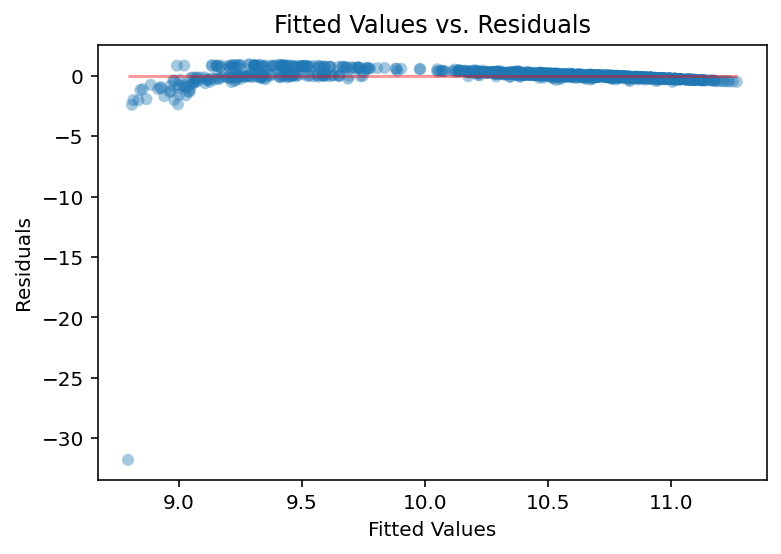

In [272]:
fittedvals = model_log.fittedvalues
residuals = model_log.resid

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(fittedvals, residuals, alpha=0.4, edgecolors='none')
ax.hlines(0, xmin=min(fittedvals), xmax=max(fittedvals), colors='r', alpha=0.4)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted Values vs. Residuals")
plt.show()

In [267]:
bp_test = het_breuschpagan(model_log.resid, model_log.model.exog)
labels = ['BP Statistic', 'BP-Test p-value']
bp_result = dict(zip(labels, bp_test))
if bp_result['BP-Test p-value'] < 0.05:
    print('Reject H0, there’s a significant heteroscedasticity problem at the 95% confidence level.')
else:
    print('Can\'t reject H0, there’s no significant heteroscedasticity problem at the 95% confidence level.')

Can't reject H0, there’s no significant heteroscedasticity problem at the 95% confidence level.


In [268]:
bp_result['BP-Test p-value']

0.13684854796221965

## 5. Check Linearity

In [240]:
bmi = df_droppoints['bmi']
children = df_droppoints['children']
age = df_droppoints['age']
bmi_log = [i**8 for i in bmi]
children_log = [i**2 for i in children] # smoothing
age_log = [i**.5 for i in age] # smoothing

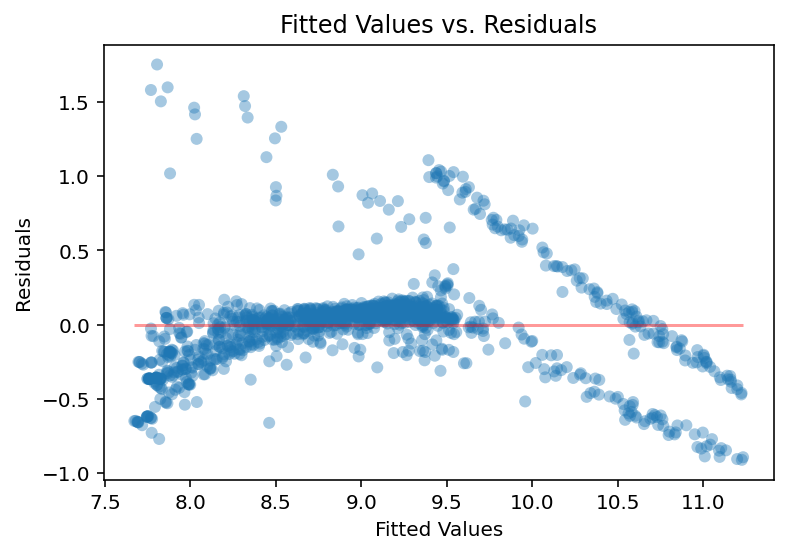

In [241]:
model_linear = smf.ols('charges_log ~ age_log + bmi_log + children_log + sex + smoker + region', data=df_droppoints).fit()
fittedvals = model_linear.fittedvalues
residuals = model_linear.resid

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(fittedvals, residuals, alpha=0.4, edgecolors='none')
ax.hlines(0, xmin=min(fittedvals), xmax=max(fittedvals), colors='r', alpha=0.4)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted Values vs. Residuals")
plt.show()

In [174]:
bp_test = het_breuschpagan(model_linear.resid, model_linear.model.exog)
labels = ['BP Statistic', 'BP-Test p-value']
bp_result = dict(zip(labels, bp_test))
if bp_result['BP-Test p-value'] < 0.05:
    print('Reject H0, there’s a significant heteroscedasticity problem at the 95% confidence level.')
else:
    print('Can\'t reject H0, there’s no significant heteroscedasticity problem at the 95% confidence level.')

Reject H0, there’s a significant heteroscedasticity problem at the 95% confidence level.


In [175]:
bp_result['BP-Test p-value']

6.038551559012585e-32

## 5. Check Normality

### (1) Hist Plot

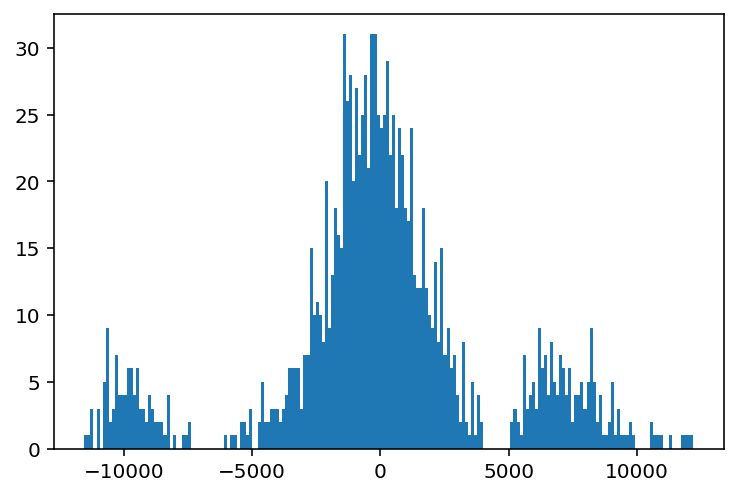

In [233]:
s = stats.skew(model_log.resid)
k = stats.kurtosis(model_log.resid)
plt.hist(model_weighted.resid, bins=200)
plt.show()

### (2) QQ Plot

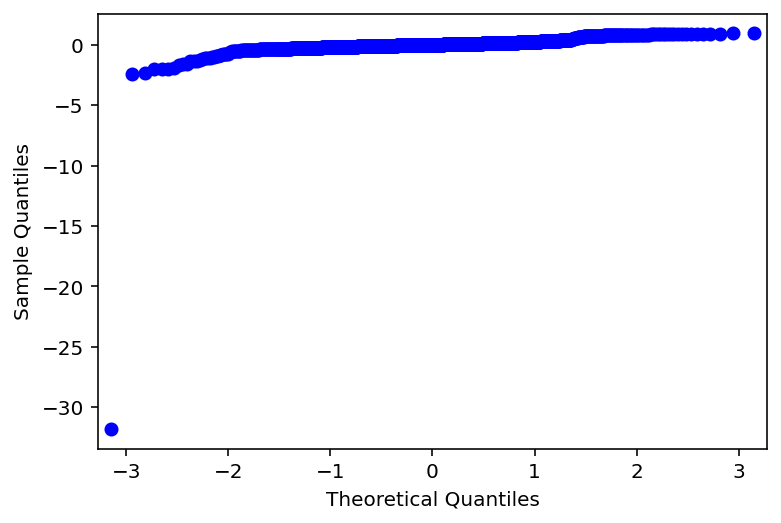

In [229]:
fig = sm.qqplot(model_log.resid)

### (3) K-Square Test

In [230]:
KstestResult = kstest(model_log.resid,'norm')
if KstestResult[1] < 0.05:
    print('Reject H0, the model is not normality at 95% confidence level.')
else:
    print('Can\'t reject H0, the model is normality at 95% confidence level.')

Reject H0, the model is not normality at 95% confidence level.


### (4) JB Test

In [102]:
if stats.jarque_bera(model_log.resid)[1] < 0.05:
    print('Reject H0, the model is not normality at 95% confidence level.')
else:
    print('Can\'t reject H0, the model is normality at 95% confidence level.')

Reject H0, the model is not normality at 95% confidence level.


### (5) Box-Cox Transformation

In [104]:
fitted_charges, fitted_lambda = boxcox(charges_log)
model_boxcox = smf.ols('fitted_charges ~ age + bmi + children + sex + smoker + region', data=df_droppoints).fit()
model_boxcox.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         fitted_charges   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     1012.
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:53:24   Log-Likelihood:                -44.090
No. Observations:                1237   AIC:                             106.2
Df Residuals:                    1228   BIC:                             152.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.1161      0.043    117.717      0.000       5.031       5.201
sex[T.male]            -0.0622      0.014     -4.320      0.000      -0.090      -0.034
smoker[T.yes]           1.2634      0.018     69.221      0.000       1.228       1.299
region[T.northwest]    -0.0765      0.021     -3.698      0.000      -0.117      -0.036
region[T.southeast]    -0.1219      0.021     -5.867      0.000      -0.163      -0.081
region[T.southwest]    -0.0915      0.021     -4.442      0.000      -0.132      -0.051
age                     0.0277      0.001     53.934      0.000       0.027       0.029
bmi                     0.0099      0.001      7.775      0.000       0.007       0.012
children                0.0781      0.006     13.080      0.000       0.066       0.090
==============================================================================
Omnibus:                      262.438   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1082.941
Skew:                           0.955   Prob(JB):                    6.96e-236
Kurtosis:                       7.167   Cond. No.                         318.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

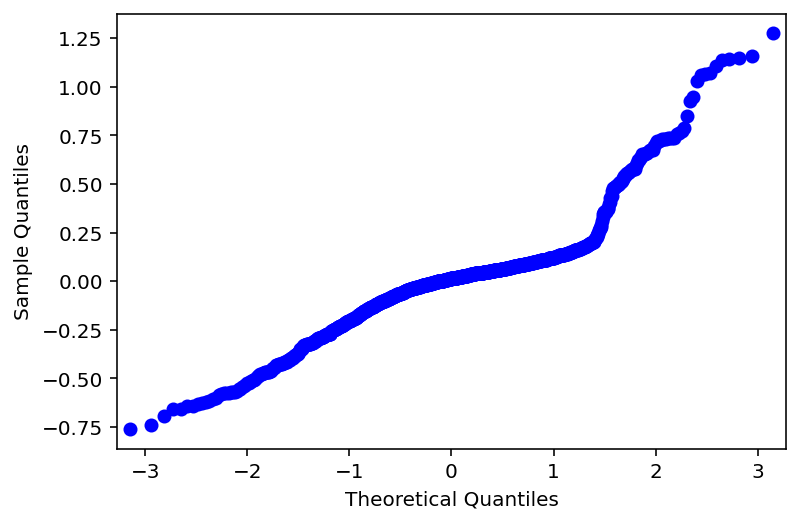

In [105]:
fig = sm.qqplot(model_boxcox.resid)

In [106]:
KstestResult = kstest(model_boxcox.resid,'norm')
if KstestResult[1] < 0.05:
    print('Reject H0, the model is not normality at 95% confidence level.')
else:
    print('Can\'t reject H0, the model is normality at 95% confidence level.')

Reject H0, the model is not normality at 95% confidence level.
